In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import sys
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,RidgeCV
from dca.cov_util import form_lag_matrix, calc_cross_cov_mats_from_data
import glob
import pdb
from statsmodels.tsa import stattools
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pyuoi.linear_model.var import VAR

In [4]:
sys.path.append('/home/akumar/nse/neural_control')
from loaders import load_sabes
from decoders import lr_decoder
from utils import apply_df_filters

In [5]:
# Re-do the CCA analysis at 50 ms

### Preprocess and save

In [5]:
# Select the indy data file that has both M1/S1 and one loco datafile that seems to give decent decoding performance
data_files = ['/mnt/Secondary/data/sabes/indy_20160426_01.mat']
data_files.extend(glob.glob('/mnt/Secondary/data/sabes/loco*'))

In [13]:
d = data_files[0].split('/')[-1]

In [15]:
for didx, data_file in enumerate(data_files):
    print('Loading M1')
    datM1 = load_sabes(data_file, bin_width=25, filter_fn='none', filter_kwargs={}, region='M1')
    print('Loading S1')
    datS1 = load_sabes(data_file, bin_width=25, filter_fn='none', filter_kwargs={}, region='S1')

    d = data_file.split('/')[-1].split('.mat')[0]
    # Save away with the loader parameters
    with open('/mnt/Secondary/data/sabes_tmp25/%s.pkl' % d, 'wb') as f:
        f.write(pickle.dumps(datM1))
        f.write(pickle.dumps(datS1))

Loading M1
Loading S1
96
Loading M1
Loading S1
96
Loading M1
Loading S1
96
Loading M1
Loading S1
96
Loading M1
Loading S1
96
Loading M1
Loading S1
96
Loading M1
Loading S1
96
Loading M1
Loading S1
96
Loading M1
Loading S1
96
Loading M1
Loading S1
96
Loading M1
Loading S1
96


### Canonical Correlation Coefficients and S1 -> CC R2

#### Consolidating

In [15]:
# CCA across timescales
fls = glob.glob('/mnt/Secondary/data/mpi_cc250/*.pkl')

In [16]:
rl = []
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                result = pickle.load(f)
                rl.append(result)
            except (EOFError):
                break

In [17]:
df = pd.DataFrame(rl)

In [22]:
df.iloc[0]['fl']

'/mnt/Secondary/data/sabes_tmp50/indy_20160426_01.pkl'

In [10]:
# Get the canonical correlation coefficients.
cc_coefs = np.zeros((df.shape[0], 6))
r2_scores = np.zeros(df.shape[0])
# These are the 

for i in range(df.shape[0]):
    print(i)
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    lag = df.iloc[i]['lag']
    w = df.iloc[i]['win']


    # Apply window and lag relative to each other
    if lag != 0:
        x = X[:-lag, :]
        y = Y[lag:, :]
    else:
        x = X
        y = Y

    if w > 1:
        x = form_lag_matrix(x, w)
        y = form_lag_matrix(y, w)


    model = df.iloc[i]['ccamodel']
    X_c, Y_c = model.transform(x, y)
    ccc2 = np.array([scipy.stats.pearsonr(X_c[:, j], Y_c[:, j])[0] for j in range(X_c.shape[1])])    
    cc_coefs[i, :] = ccc2
    r2_scores[i] = model.score(x, y)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


In [11]:
df['cc_coefs'] = list(cc_coefs)
df['r2_scores'] = list(r2_scores)

In [12]:
with open('/mnt/Secondary/data/postprocessed/cca_timescales_df50.pkl', 'wb') as f:
    f.write(pickle.dumps(df))

#### Plotting

In [5]:
with open('/mnt/Secondary/data/postprocessed/cca_timescales_df50.pkl', 'rb') as f:
    df50 = pickle.load(f)
with open('/mnt/Secondary/data/postprocessed/cca_timescales_df25.pkl', 'rb') as f:
    df25 = pickle.load(f)

In [25]:
d = apply_df_filters(df50, win=1, lag=0)

In [27]:
d.keys()

Index(['dfile', 'bin_width', 'filter_fn', 'filter_kwargs', 'lag', 'win',
       'ccamodel', 'fl', 'cc_coefs', 'r2_scores'],
      dtype='object')

In [23]:
np.unique(df50['fl'].values)

array(['/mnt/Secondary/data/sabes_tmp50/indy_20160426_01.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170210_03.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170213_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170214_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170215_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170216_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170217_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170227_04.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170228_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170301_05.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170302_02.pkl'],
      dtype=object)

In [7]:
df50 = apply_df_filters(df50, lag=0, win=3)
df25 = apply_df_filters(df25, lag=0, win=3)

In [67]:
df50.iloc[0]['

array([0.84588248, 0.65291219, 0.55105422, 0.50854586, 0.46507086,
       0.4124928 ])

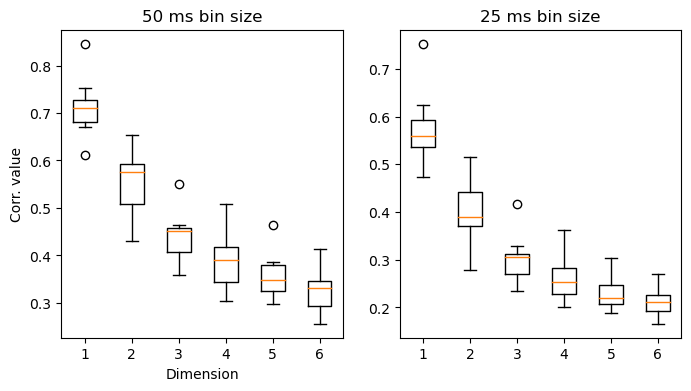

In [68]:
# Plot the distribution of canonical correlation coefficients across dimensions
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

cc_coefs = np.zeros((11, 6, 2))
for i in range(df50.shape[0]):
    cc_coefs[i, :, 0] = df50.iloc[i]['cc_coefs']
    cc_coefs[i, :, 1] = df25.iloc[i]['cc_coefs']

ax[0].boxplot(cc_coefs[:, :, 0])
ax[1].boxplot(cc_coefs[:, :, 1])

ax[0].set_title('50 ms bin size')
ax[1].set_title('25 ms bin size')

ax[0].set_ylabel('Corr. value')
ax[0].set_xlabel('Dimension')

fig.savefig('/home/akumar/nse/neural_control/figs/cca/cc_coef.pdf', bbox_inches='tight', pad_inches=0)

#### Direct regression calculation

In [193]:
# What is the raw r2 of prediction across the different preprocesing parameters? CCA doesn't do very well, because we try to compress down to 6 dimensions. Let's just do ambient regression. This dovetails nicely
# with a poisson GLM regressiona

In [5]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [17]:
# Using just linear regression to pre-empt ask to do use Ridge on the behavioral decoding (and more generally on the role of the decoder)

In [8]:
df = [df50, df25]

In [71]:
lr2 = np.zeros((df50.shape[0], 5, 2))
for i in tqdm(range(df50.shape[0])):
    for k in range(2):
        with open(df[k].iloc[i]['fl'], 'rb') as f:
            datM1 = pickle.load(f)
            datS1 = pickle.load(f)

        Y = datM1['spike_rates'].squeeze()
        X = datS1['spike_rates'].squeeze()

        lag = df[k].iloc[i]['lag']
        w = df[k].iloc[i]['win']

        # Apply window and lag relative to each other
        if lag != 0:
            x = X[:-lag, :]
            y = Y[lag:, :]
        else:
            x = X
            y = Y


        x = StandardScaler().fit_transform(x)
        y = StandardScaler().fit_transform(y)

        for j, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5).split(x)):

            xtrain = x[train_idxs]
            xtest = x[test_idxs]

            ytrain = y[train_idxs]
            ytest = y[test_idxs]

            xtest = x[test_idxs]
            ytest = y[test_idxs]

            xtrain = form_lag_matrix(xtrain, 3)
            xtest = form_lag_matrix(xtest, 3)

            ytrain = ytrain[2:]
            ytest = ytest[2:]

            linmodel = RidgeCV()
            linmodel.fit(xtrain, ytrain)

            lr2[i, j, k] = linmodel.score(xtest, ytest)

100%|██████████| 11/11 [03:20<00:00, 18.20s/it]


In [10]:
lr2_cc = np.zeros((df[0].shape[0], 5, 6, 2))

for i in tqdm(range(df[0].shape[0])):
    for k in range(2):
        with open(df[k].iloc[i]['fl'], 'rb') as f:
            datM1 = pickle.load(f)
            datS1 = pickle.load(f)

        y = datM1['spike_rates'].squeeze()
        x = datS1['spike_rates'].squeeze()

        lag = df[k].iloc[i]['lag']
        w = df[k].iloc[i]['win']

        model = df[k].iloc[i]['ccamodel']

        if lag != 0:
            x = x[:-lag, :]
            y = y[lag:, :]


        x = form_lag_matrix(x, 3)
        y = form_lag_matrix(y, 3)

        _, yt = model.transform(x, y)

        x = StandardScaler().fit_transform(x)
        for d in range(1, 7):
            y = StandardScaler().fit_transform(yt)[:, 0:d]
            for j, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5).split(x)):
                xtrain = x[train_idxs]
                xtest = x[test_idxs]

                ytrain = y[train_idxs]
                ytest = y[test_idxs]

                linmodel = RidgeCV()
                linmodel.fit(xtrain, ytrain) 
                lr2_cc[i, j, d-1, k] = linmodel.score(xtest, ytest)

100%|██████████| 11/11 [10:26<00:00, 56.92s/it]


In [12]:
with open('m1s1_regression50_25.dat', 'wb') as f:
    #f.write(pickle.dumps(lr2))
    f.write(pickle.dumps(lr2_cc))

# with open('m1s1_regression.dat', 'rb') as f:
#     lr2 = pickle.load(f)
#     lr2_cc = pickle.load(f)

In [58]:
lr2.shape

(11, 5, 2)

In [82]:
lr2_cc[0, :, 4, 0]

array([0.7097193 , 0.73540844, 0.72976912, 0.73130051, 0.60238011])

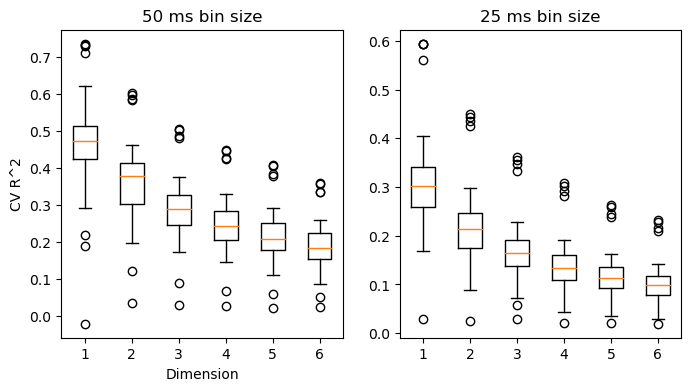

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].boxplot(lr2_cc[..., 0].reshape((-1, 6)))
ax[1].boxplot(lr2_cc[..., 1].reshape(-1, 6))

ax[0].set_title('50 ms bin size')
ax[1].set_title('25 ms bin size')

ax[0].set_ylabel('CV R^2')
ax[0].set_xlabel('Dimension')

fig.savefig('/home/akumar/nse/neural_control/figs/cca/s1m1cc_r2.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Project the M1 data onto the most predictable direction...
# How does one do that? Project onto top CCA vectors?

In [ ]:
# Which preprocessing parameters are responsible for the really bad regression?

### Subspace analysis

In [5]:
with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    rl = pickle.load(f)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
loco_df = pd.DataFrame(rl)

In [7]:
# Apply global filter for decoding and loading arguments
loco_df50 = apply_df_filters(loco_df, loader_args = {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'},
                           decoder_args = {'trainlag': 4, 'testlag': 4, 'decoding_window': 5})

In [9]:
# Write to file so we can simultaneously work with 25/50 ms dataframes in memory
# with open('loco_df50.dat', 'wb') as f:
#     f.write(pickle.dumps(loco_df50))
with open('loco_df50.dat', 'rb') as f:
    loco_df50 = pickle.load(f)

In [10]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    rl = pickle.load(f)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [18]:
indy_df50 = pd.DataFrame(rl)

In [13]:
# Consolidating 25 ms dimreduc fits
src_path = '/mnt/Secondary/data/indy_dimreduc25'
argfiles = glob.glob('%s/arg*.dat' % src_path)

result_list = []
for argfile in argfiles:

    # Open up the arg files
    with open(argfile, 'rb') as f:
        args = pickle.load(f)

    # rfile = args['results_file']
    # with open(rfile, 'rb') as f:
    #     result = pickle.load(f)

    result = [{}]
    for result_ in result:
        for k, v in args.items():
            if type(k) == dict:
                for k_, v_ in k.items():
                    result_[k_] = v_
            else:
                result_[k] = v

    result_list.extend(result)

# For ease of use, use data file names that do not involve the directory path
for r in result_list:
    r['data_file'] = r['data_file'].split('/')[-1]


In [14]:
indy_df25 = pd.DataFrame(r)

In [15]:
# Consolidating 25 ms dimreduc fits
src_path = '/mnt/Secondary/data/loco_dimreduc25'
argfiles = glob.glob('%s/arg*.dat' % src_path)

result_list = []
for argfile in argfiles:

    # Open up the arg files
    with open(argfile, 'rb') as f:
        args = pickle.load(f)

    # rfile = args['results_file']
    # with open(rfile, 'rb') as f:
    #     result = pickle.load(f)

    result = [{}]
    for result_ in result:
        for k, v in args.items():
            if type(k) == dict:
                for k_, v_ in k.items():
                    result_[k_] = v_
            else:
                result_[k] = v

    result_list.extend(result)

# For ease of use, use data file names that do not involve the directory path
for r in result_list:
    r['data_file'] = r['data_file'].split('/')[-1]


In [16]:
loco_df25 = pd.DataFrame(r)

In [ ]:
# Here we use Linear Regression since we aren't massively overparameterized

In [20]:
# For dimensions 2-6, perform a cross-validated regression from S1 activity to the projected activity of each of the methods.
# This has no interaction with cca. Therefore, remove the iteration over windows

# N unique cca fits x dr types x folds x dims x bin size
subspace_r2 = np.zeros((df[0].shape[0], 2, 5, 3, 2))
indy_df = [indy_df50, indy_df25]
loco_df = [loco_df50, loco_df25]

for i in tqdm(range(df[0].shape[0])):
    for h in range(2):
        with open(df[h].iloc[i]['fl'], 'rb') as f:
            datM1 = pickle.load(f)
            datS1 = pickle.load(f)

        Y = datM1['spike_rates'].squeeze()
        X = datS1['spike_rates'].squeeze()
        lag = df[h].iloc[i]['lag']
        w = df[h].iloc[i]['win']

        # Get the subspaces
        data_file = df[h].iloc[i]['fl'].split('/')[-1].split('.pkl')[0]
        data_file += '.mat'

        if 'indy' in data_file:
            pcadf = apply_df_filters(indy_df[h], data_file=data_file, dimreduc_method='PCA', dim=[2, 4, 6])
        elif 'loco' in data_file:
            pcadf = apply_df_filters(loco_df[h], data_file=data_file, dimreduc_method='PCA', dim=[2, 4, 6])

        assert(pcadf.shape[0] == 15)

        # For each fold, and dimensions 2-6, measure the min and average subspace angle
        for fold in range(5):
            for didx, dim in enumerate(np.array([2, 4, 6])):
                d_ = apply_df_filters(pcadf, dim=dim, fold_idx=fold)
                assert(d_.shape[0] == 1)

                Vpca = d_.iloc[0]['coef']

                ytrain = Y[d_.iloc[0]['train_idxs']] @ Vpca
                ytest = Y[d_.iloc[0]['test_idxs']] @ Vpca

                xtrain = X[d_.iloc[0]['train_idxs']]
                xtest = X[d_.iloc[0]['test_idxs']]

                # Apply window and lag relative to each other
                if lag != 0:
                    xtrain = xtrain[:-lag, :]
                    ytrain = ytrain[lag:, :]

                    xtest = xtest[:-lag, :]
                    ytest = ytest[lag:, :]

                # Window
                xtrain = form_lag_matrix(xtrain, w)
                xtest = form_lag_matrix(xtest, w)

                ytrain = form_lag_matrix(ytrain, w)
                ytest = form_lag_matrix(ytest, w)

                ytrain = StandardScaler().fit_transform(ytrain)
                xtrain = StandardScaler().fit_transform(xtrain)

                ytest = StandardScaler().fit_transform(ytest)
                xtest = StandardScaler().fit_transform(xtest)

                linmodel = LinearRegression()
                linmodel.fit(xtrain, ytrain)
                subspace_r2[i, 0, fold, didx, h] = linmodel.score(xtest, ytest)


        if 'indy' in data_file:
            lqgdf = apply_df_filters(indy_df[h], data_file=data_file, dimreduc_method='LQGCA', dim=[2, 4, 6])
        elif 'loco' in data_file:
            lqgdf = apply_df_filters(loco_df[h], data_file=data_file, dimreduc_method='LQGCA', dim=[2, 4, 6])

        assert(lqgdf.shape[0] == 15)

        for fold in range(5):
            for didx, dim in enumerate(np.array([2, 4, 6])):
                d_ = apply_df_filters(lqgdf, dim=dim, fold_idx=fold)
                assert(d_.shape[0] == 1)
                
                Vlqg = d_.iloc[0]['coef']

                ytrain = Y[d_.iloc[0]['train_idxs']] @ Vlqg
                ytest = Y[d_.iloc[0]['test_idxs']] @ Vlqg

                xtrain = X[d_.iloc[0]['train_idxs']]
                xtest = X[d_.iloc[0]['test_idxs']]

                # Apply window and lag relative to each other
                if lag != 0:
                    xtrain = xtrain[:-lag, :]
                    ytrain = ytrain[lag:, :]

                    xtest = xtest[:-lag, :]
                    ytest = ytest[lag:, :]

                # Window
                if w > 1:
                    xtrain = form_lag_matrix(xtrain, w)
                    xtest = form_lag_matrix(xtest, w)

                    ytrain = form_lag_matrix(ytrain, w)
                    ytest = form_lag_matrix(ytest, w)


                ytrain = StandardScaler().fit_transform(ytrain)
                xtrain = StandardScaler().fit_transform(xtrain)

                ytest = StandardScaler().fit_transform(ytest)
                xtest = StandardScaler().fit_transform(xtest)

                linmodel = LinearRegression()
                linmodel.fit(xtrain, ytrain)    
                subspace_r2[i, 1, fold, didx, h] = linmodel.score(xtest, ytest)

        # For dimensions 2-6, perform a cross-validated regression from S1 activity to the projected activity of each of the methods.
        # This has no interaction with cca
        

  0%|          | 0/11 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'iloc'

In [56]:
# with open('s1_subspace_regression50.pkl', 'wb') as f:
#     f.write(pickle.dumps(subspace_r2))
with open('s1_subspace_regression50.pkl', 'rb') as f:
    subspace_r2 = pickle.load(f)

(array([19., 19., 15., 19.,  9., 10.,  4.,  2.,  0.,  2.]),
 array([-0.00387966,  0.03890917,  0.08169799,  0.12448682,  0.16727564,
         0.21006447,  0.2528533 ,  0.29564212,  0.33843095,  0.38121978,
         0.4240086 ]),
 <BarContainer object of 10 artists>)

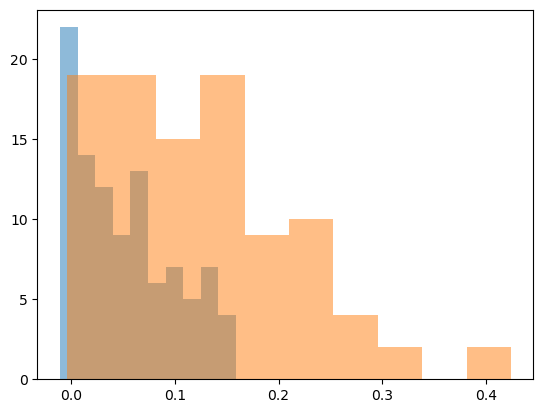

In [61]:
plt.hist(np.mean(subspace_r2[:, 0, :, 0], axis=1), alpha=0.5)
plt.hist(np.mean(subspace_r2[:, 1, :, 0], axis=1), alpha=0.5)

In [32]:
# we messed up window function so for now restrict analysis to window size 1
w1df = apply_df_filters(dfvalid, win=1)
sr2_act_pairs = np.zeros((2, w1df.shape[0]//2, 6))

lag_cols = ['r', 'k', 'b']
#win_markers = ['s', 't', 'o']
#win_cols = ['r', 'g', 'b']

cols1 = []
cols2 = []
for j in range(2):
    cols1.append([])
    w1dfd = apply_df_filters(w1df, didx=j, reset_index=False)
    for i in range(w1dfd.shape[0]):
        acf_df_ = apply_df_filters(acfdf, didx=w1dfd.iloc[i]['didx'], bin_width=w1dfd.iloc[i]['bin_width'], filter_fn=w1dfd.iloc[i]['filter_fn'], filter_kwargs=w1dfd.iloc[i]['filter_kwargs'])
        assert(acf_df_.shape[0] == 1)
        sr2_act_pairs[j, i, 0] = np.mean(subspace_r2[w1dfd.index[i], :, 0, 0])
        sr2_act_pairs[j, i, 1] = np.mean(subspace_r2[w1dfd.index[i], :, 1, 0])
        sr2_act_pairs[j, i, 2] = np.mean(subspace_r2[w1dfd.index[i], :, 2, 0])
        sr2_act_pairs[j, i, 3] = np.mean(subspace_r2[w1dfd.index[i], :, 3, 0])
        sr2_act_pairs[j, i, 4] = np.mean(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))
        sr2_act_pairs[j, i, 5] = np.median(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))

        cols1[j].append(lag_cols[lags.index(w1dfd.iloc[i]['lag'])])

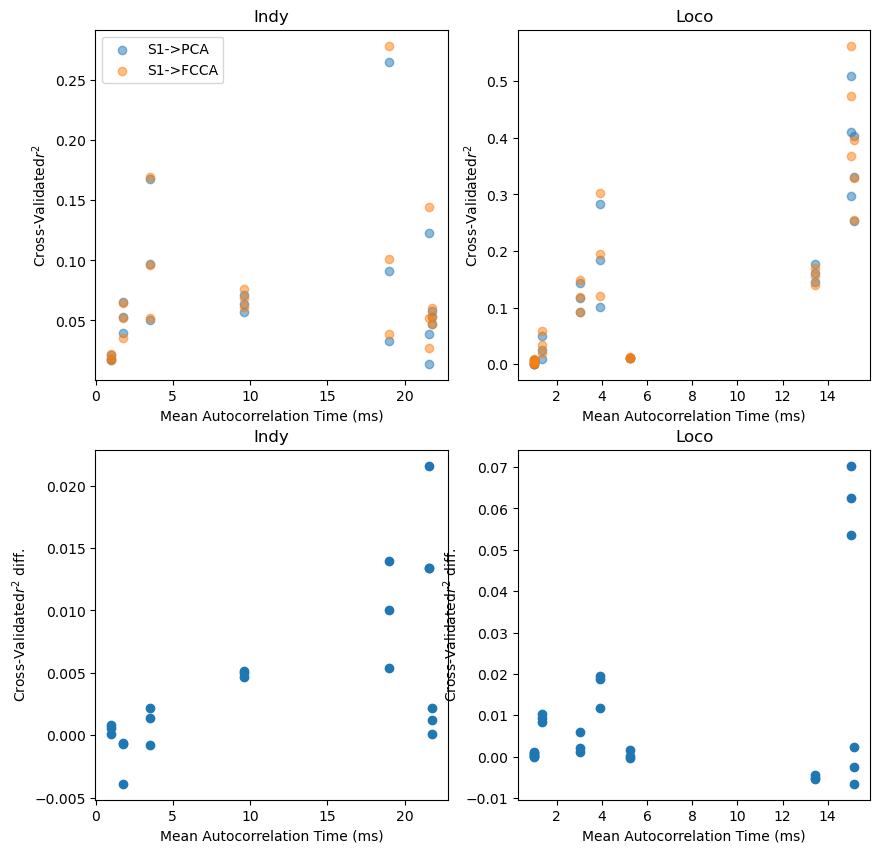

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

#r2_act_pairs[r2_act_pairs < -1] = np.nan

ax[0, 0].scatter(sr2_act_pairs[0, :, 4], sr2_act_pairs[0, :, 0], alpha=0.5)
ax[0, 0].scatter(sr2_act_pairs[0, :, 4], sr2_act_pairs[0, :, 1], alpha=0.5)
ax[0, 1].scatter(sr2_act_pairs[1, :, 4], sr2_act_pairs[1, :, 0], alpha=0.5)
ax[0, 1].scatter(sr2_act_pairs[1, :, 4], sr2_act_pairs[1, :, 1], alpha=0.5)

ax[0, 0].set_ylabel('Cross-Validated' + r'$r^2$')
ax[0, 1].set_ylabel('Cross-Validated' + r'$r^2$')
ax[0, 0].set_xlabel('Mean Autocorrelation Time (ms)')
ax[0, 1].set_xlabel('Mean Autocorrelation Time (ms)')
ax[0, 0].set_title('Indy')
ax[0, 1].set_title('Loco')
ax[0, 0].legend(['S1->PCA', 'S1->FCCA'])

ax[1, 0].scatter(sr2_act_pairs[0, :, 4], sr2_act_pairs[0, :, 1] - sr2_act_pairs[0, :, 0])
ax[1, 1].scatter(sr2_act_pairs[1, :, 4], sr2_act_pairs[1, :, 1] - sr2_act_pairs[1, :, 0])

ax[1, 0].set_ylabel('Cross-Validated' + r'$r^2$ diff.')
ax[1, 1].set_ylabel('Cross-Validated' + r'$r^2$ diff.')
ax[1, 0].set_xlabel('Mean Autocorrelation Time (ms)')
ax[1, 1].set_xlabel('Mean Autocorrelation Time (ms)')
ax[1, 0].set_title('Indy')
ax[1, 1].set_title('Loco')

fig.savefig('/home/akumar/nse/neural_control/figs/timescales/s1m1r2_subspaces.pdf', bbox_inches='tight',  pad_inches=0)

In [ ]:
# What about bin size 50 ms?

In [77]:
# Prediction of subspace activity from the M1 CC vector

In [12]:
np.unique(indy_df['data_file'].values)

array(['indy_20160426_01.mat', 'indy_20160622_01.mat',
       'indy_20160624_03.mat', 'indy_20160627_01.mat',
       'indy_20160630_01.mat', 'indy_20160915_01.mat',
       'indy_20160921_01.mat', 'indy_20160930_02.mat',
       'indy_20160930_05.mat', 'indy_20161005_06.mat',
       'indy_20161006_02.mat', 'indy_20161007_02.mat',
       'indy_20161011_03.mat', 'indy_20161013_03.mat',
       'indy_20161014_04.mat', 'indy_20161017_02.mat',
       'indy_20161024_03.mat', 'indy_20161025_04.mat',
       'indy_20161026_03.mat', 'indy_20161027_03.mat',
       'indy_20161206_02.mat', 'indy_20161207_02.mat',
       'indy_20161212_02.mat', 'indy_20161220_02.mat',
       'indy_20170123_02.mat', 'indy_20170124_01.mat',
       'indy_20170127_03.mat', 'indy_20170131_02.mat'], dtype=object)

In [16]:
loco_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'decoder', 'decoder_args',
       'decoder_obj', 'r2', 'data_file', 'loader', 'loader_args', 'task_args',
       'data_path', 'results_file'],
      dtype='object')

In [38]:
d_ = apply_df_filters(indy_df, data_file=np.unique(indy_df['data_file'].values)[0], dimreduc_method='LQGCA', dim=6)

In [40]:
d_ = apply_df_filters(loco_df, data_file=np.unique(loco_df['data_file'].values)[0], dimreduc_method='LQGCA', dim=6)

In [48]:
cc2ssr2 = np.zeros((df.shape[0], 2, 5))
dim = 6
for i in tqdm(range(df.shape[0])):
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    y = datM1['spike_rates'].squeeze()
    x = datS1['spike_rates'].squeeze()

    lag = df.iloc[i]['lag']
    w = df.iloc[i]['win']
    
    model = df.iloc[i]['ccamodel']

    # Get the subspaces
    data_file = df.iloc[i]['fl'].split('/')[-1].split('.pkl')[0]
    data_file += '.mat'

    if 'indy' in data_file:
        pcadf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='PCA', dim=6)
    elif 'loco' in data_file:
        pcadf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='PCA', dim=6)

    assert(pcadf.shape[0] == 5)

    # For each fold, and dimensions 2-6, measure the min and average subspace angle
    for fold in range(5):
        d_ = apply_df_filters(pcadf, fold_idx=fold)
        Vpca = d_.iloc[0]['coef']

        xtrain = y[d_.iloc[0]['train_idxs']]
        xtest = y[d_.iloc[0]['test_idxs']]

        # M1 PCA
        ytrain = y[d_.iloc[0]['train_idxs']] @ Vpca
        ytest = y[d_.iloc[0]['test_idxs']] @ Vpca        

        # Apply window and lag relative to each other
        if lag != 0:
            xtrain = xtrain[:-lag, :]
            xtest = xtest[:-lag, :]

            ytrain = ytrain[lag:, :]  
            ytest = ytest[lag:, :]

        # Window
        if w > 1:
            xtrain = form_lag_matrix(xtrain, w)
            xtest = form_lag_matrix(xtest, w)

            ytrain = form_lag_matrix(ytrain, w)
            ytest = form_lag_matrix(ytest, w)


        # M1 CCA
        xtrain = xtrain @ model.y_weights_
        xtest = xtest @ model.y_weights_

        ytrain = StandardScaler().fit_transform(ytrain)
        xtrain = StandardScaler().fit_transform(xtrain)

        ytest = StandardScaler().fit_transform(ytest)
        xtest = StandardScaler().fit_transform(xtest)

        linmodel = RidgeCV()
        linmodel.fit(xtrain, ytrain)
        cc2ssr2[i, 0, fold] = linmodel.score(xtest, ytest)

    if 'indy' in data_file:
        lqgdf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='LQGCA', dim=6)
    elif 'loco' in data_file:
        lqgdf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='LQGCA', dim=6)

    assert(lqgdf.shape[0] == 5)

    for fold in range(5):
        d_ = apply_df_filters(lqgdf, fold_idx=fold)
        if d_.shape[0] == 0:
            cc2ssr2[i, 1, fold] = np.nan
            continue

        Vlqg = d_.iloc[0]['coef']
        # M1 CCA
        xtrain = y[d_.iloc[0]['train_idxs']]
        xtest = y[d_.iloc[0]['test_idxs']]

        ytrain = y[d_.iloc[0]['train_idxs']] @ Vlqg
        ytest = y[d_.iloc[0]['test_idxs']] @ Vlqg

        # Apply window and lag relative to each other
        if lag != 0:
            xtrain = xtrain[:-lag, :]
            xtest = xtest[:-lag, :]

            ytrain = ytrain[lag:, :]  
            ytest = ytest[lag:, :]

        # Window
        if w > 1:
            xtrain = form_lag_matrix(xtrain, w)
            xtest = form_lag_matrix(xtest, w)

            ytrain = form_lag_matrix(ytrain, w)
            ytest = form_lag_matrix(ytest, w)


        xtrain = xtrain @ model.y_weights_
        xtest = xtest @ model.y_weights_

        ytrain = StandardScaler().fit_transform(ytrain)
        xtrain = StandardScaler().fit_transform(xtrain)

        ytest = StandardScaler().fit_transform(ytest)
        xtest = StandardScaler().fit_transform(xtest)

        linmodel = RidgeCV()
        linmodel.fit(xtrain, ytrain)
        cc2ssr2[i, 1, fold] = linmodel.score(xtest, ytest)


100%|██████████| 99/99 [02:40<00:00,  1.62s/it]


(array([34., 20., 11.,  4.,  9.,  7.,  2.,  3.,  5.,  4.]),
 array([0.02204897, 0.09743293, 0.17281688, 0.24820083, 0.32358478,
        0.39896873, 0.47435268, 0.54973664, 0.62512059, 0.70050454,
        0.77588849]),
 <BarContainer object of 10 artists>)

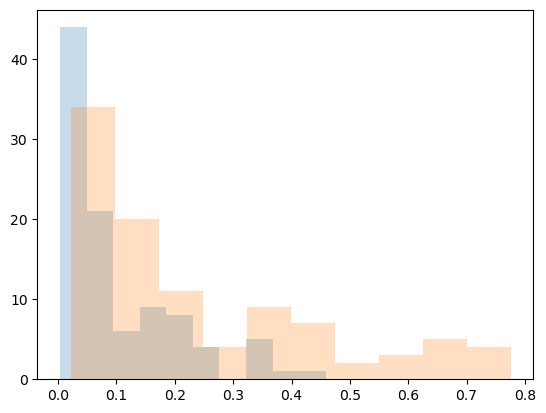

In [64]:
plt.hist(np.mean(cc2ssr2[:, 0, :], axis=1), alpha=0.25)
plt.hist(np.mean(cc2ssr2[:, 1, :], axis=1), alpha=0.25)

In [51]:
np.mean(cc2ssr2[:, 1, :], axis=1) - np.mean(cc2ssr2[:, 0, :], axis=1)

array([0.13119749, 0.12825803, 0.10537071, 0.25273253, 0.22051812,
       0.21721938, 0.49107504, 0.55106378, 0.72100507, 0.04144869,
       0.03637283, 0.02362346, 0.08877626, 0.07190758, 0.05089882,
       0.1880391 , 0.20919292, 0.28040963, 0.0353809 , 0.0237175 ,
       0.01211046, 0.06850628, 0.05429097, 0.02563586, 0.14172644,
       0.17353139, 0.27461943, 0.06870167, 0.05258363, 0.03668884,
       0.13415045, 0.1217414 , 0.06307176, 0.20790113, 0.26552823,
       0.44350313, 0.03884908, 0.02479804, 0.01189555, 0.09418211,
       0.0718368 , 0.02387343, 0.17036468, 0.20597081, 0.36999481,
       0.0544188 , 0.03716178, 0.02477869, 0.1131596 , 0.09531719,
       0.04534138, 0.19187479, 0.23043388, 0.39249103, 0.03758336,
       0.02848694, 0.02518314, 0.09478605, 0.08389954, 0.05192255,
       0.17732901, 0.20568243, 0.31964149, 0.06169885, 0.04703204,
       0.03085163, 0.12329333, 0.10326218, 0.05727647, 0.22255301,
       0.26508753, 0.43624669, 0.05432645, 0.03995213, 0.02104

In [47]:
# we messed up window function so for now restrict analysis to window size 1
w1df = apply_df_filters(dfvalid, win=1)
sr2_act_pairs = np.zeros((2, w1df.shape[0]//2, 6, 5))

lag_cols = ['r', 'k', 'b']
#win_markers = ['s', 't', 'o']
#win_cols = ['r', 'g', 'b']

cols1 = []
cols2 = []
for j in range(2):
    cols1.append([])
    w1dfd = apply_df_filters(w1df, didx=j, reset_index=False)
    for i in range(w1dfd.shape[0]):
        acf_df_ = apply_df_filters(acfdf, didx=w1dfd.iloc[i]['didx'], bin_width=w1dfd.iloc[i]['bin_width'], filter_fn=w1dfd.iloc[i]['filter_fn'], filter_kwargs=w1dfd.iloc[i]['filter_kwargs'])
        assert(acf_df_.shape[0] == 1)
        sr2_act_pairs[j, i, 0, :] = cc2ssr2[w1dfd.index[i], 0, :]
        sr2_act_pairs[j, i, 1, :] = cc2ssr2[w1dfd.index[i], 1, :]
        sr2_act_pairs[j, i, 2, :] = cc2ssr2[w1dfd.index[i], 2, :]
        sr2_act_pairs[j, i, 3, :] = cc2ssr2[w1dfd.index[i], 3, :]

        sr2_act_pairs[j, i, 4, 0] = np.mean(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))
        sr2_act_pairs[j, i, 5, 0] = np.median(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))


        cols1[j].append(lag_cols[lags.index(w1dfd.iloc[i]['lag'])])

/tmp/ipykernel_8719/419360718.py:5: RuntimeWarning: Mean of empty slice
  ax[0, 0].errorbar(sr2_act_pairs[0, :, 4, 0], np.nanmean(sr2_act_pairs[0, :, 0, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[0, :, 0, :], axis=-1), alpha=0.5, fmt='o')
/tmp/ipykernel_8719/419360718.py:6: RuntimeWarning: Mean of empty slice
  ax[0, 0].errorbar(sr2_act_pairs[0, :, 4, 0], np.nanmean(sr2_act_pairs[0, :, 1, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[0, :, 1, :], axis=-1), alpha=0.5, fmt='o')
/tmp/ipykernel_8719/419360718.py:7: RuntimeWarning: Mean of empty slice
  ax[0, 1].errorbar(sr2_act_pairs[1, :, 4, 0], np.nanmean(sr2_act_pairs[1, :, 0, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[1, :, 0, :], axis=-1), alpha=0.5, fmt='o')
/tmp/ipykernel_8719/419360718.py:18: RuntimeWarning: Mean of empty slice
  ax[1, 0].errorbar(sr2_act_pairs[0, :, 4, 0], np.nanmean(sr2_act_pairs[0, :, 1] - sr2_act_pairs[0, :, 0], axis=-1), yerr=np.nanstd(sr2_act_pairs[0, :, 1] - sr2_act_pairs[0, :, 0], axis=-1), fmt='o')
/tmp/ipyke

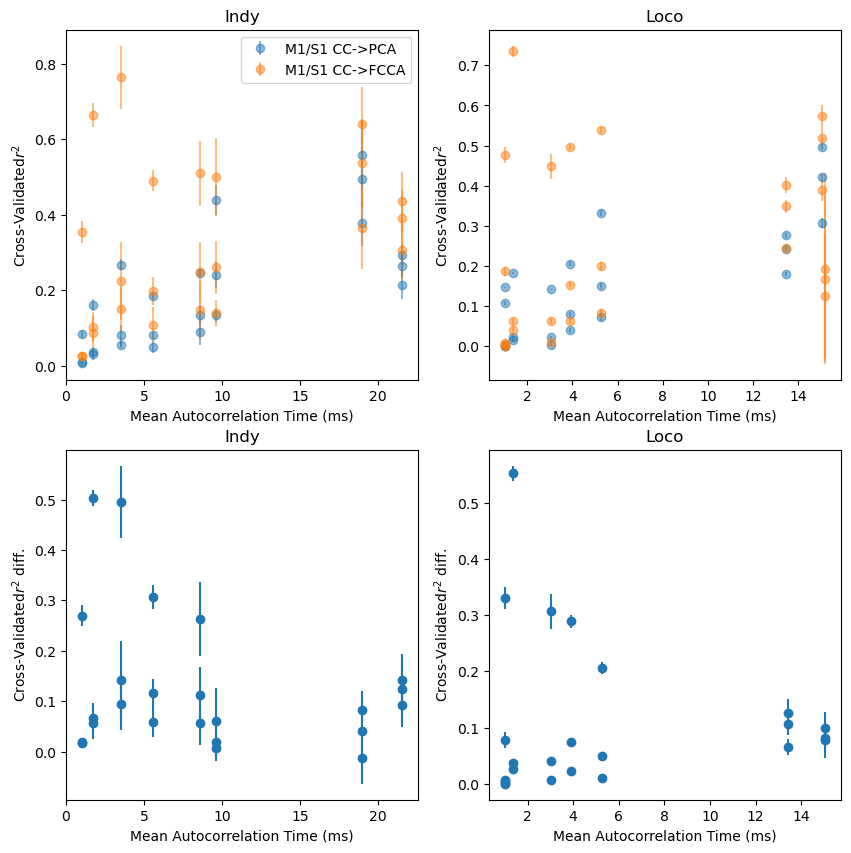

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sr2_act_pairs[sr2_act_pairs < -1] = np.nan

ax[0, 0].errorbar(sr2_act_pairs[0, :, 4, 0], np.nanmean(sr2_act_pairs[0, :, 0, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[0, :, 0, :], axis=-1), alpha=0.5, fmt='o')
ax[0, 0].errorbar(sr2_act_pairs[0, :, 4, 0], np.nanmean(sr2_act_pairs[0, :, 1, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[0, :, 1, :], axis=-1), alpha=0.5, fmt='o')
ax[0, 1].errorbar(sr2_act_pairs[1, :, 4, 0], np.nanmean(sr2_act_pairs[1, :, 0, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[1, :, 0, :], axis=-1), alpha=0.5, fmt='o')
ax[0, 1].errorbar(sr2_act_pairs[1, :, 4, 0], np.nanmean(sr2_act_pairs[1, :, 1, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[1, :, 1, :], axis=-1), alpha=0.5, fmt='o')

ax[0, 0].set_ylabel('Cross-Validated' + r'$r^2$')
ax[0, 1].set_ylabel('Cross-Validated' + r'$r^2$')
ax[0, 0].set_xlabel('Mean Autocorrelation Time (ms)')
ax[0, 1].set_xlabel('Mean Autocorrelation Time (ms)')
ax[0, 0].set_title('Indy')
ax[0, 1].set_title('Loco')
ax[0, 0].legend(['M1/S1 CC->PCA', 'M1/S1 CC->FCCA'])

ax[1, 0].errorbar(sr2_act_pairs[0, :, 4, 0], np.nanmean(sr2_act_pairs[0, :, 1] - sr2_act_pairs[0, :, 0], axis=-1), yerr=np.nanstd(sr2_act_pairs[0, :, 1] - sr2_act_pairs[0, :, 0], axis=-1), fmt='o')
ax[1, 1].errorbar(sr2_act_pairs[1, :, 4, 0], np.nanmean(sr2_act_pairs[1, :, 1] - sr2_act_pairs[1, :, 0], axis=-1), yerr=np.nanstd(sr2_act_pairs[1, :, 1] - sr2_act_pairs[1, :, 0], axis=-1), fmt='o')

ax[1, 0].set_ylabel('Cross-Validated' + r'$r^2$ diff.')
ax[1, 1].set_ylabel('Cross-Validated' + r'$r^2$ diff.')
ax[1, 0].set_xlabel('Mean Autocorrelation Time (ms)')
ax[1, 1].set_xlabel('Mean Autocorrelation Time (ms)')
ax[1, 0].set_title('Indy')
ax[1, 1].set_title('Loco')

fig.savefig('/home/akumar/nse/neural_control/figs/timescales/s1m1ccr2_subspaces.pdf', bbox_inches='tight',  pad_inches=0)

In [ ]:
# Scatter plots of the leverage scores of top canonical correlate vs. the FCA/PCA leverage scores.

In [71]:
from utils import calc_loadings

In [96]:
dim = 6
rl = []

w1df = apply_df_filters(df, win=1)

for i in tqdm(range(w1df.shape[0])):
    r = {}
    model = w1df.iloc[i]['ccamodel']

    r['cca_loadings'] = calc_loadings(model.y_weights_)
    # Get the subspaces
    data_file = w1df.iloc[i]['fl'].split('/')[-1].split('.pkl')[0]
    data_file += '.mat'

    if 'indy' in data_file:
        pcadf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='PCA', dim=6)
    elif 'loco' in data_file:
        pcadf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='PCA', dim=6)
    
    assert(pcadf.shape[0] == 5)

    # For each fold, and dimensions 2-6, measure the min and average subspace angle
    pca_loadings = []

    for fold in range(5):
        d_ = apply_df_filters(pcadf, fold_idx=fold)
        Vpca = d_.iloc[0]['coef']
        pca_loadings.append(calc_loadings(Vpca))

    r['pca_loadings'] = np.mean(np.array(pca_loadings), axis=0)

    if 'indy' in data_file:
        lqgdf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='LQGCA', dim=6)
    elif 'loco' in data_file:
        lqgdf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='LQGCA', dim=6)

    assert(lqgdf.shape[0] == 5)

    lqg_loadings = []
    for fold in range(5):
        d_ = apply_df_filters(lqgdf, fold_idx=fold)
        Vlqg = d_.iloc[0]['coef']
        lqg_loadings.append(calc_loadings(Vlqg))
    
    r['lqg_loadings'] = np.mean(np.array(lqg_loadings), axis=0)


    rl.append(r)

100%|██████████| 33/33 [00:00<00:00, 195.28it/s]


/tmp/ipykernel_5046/4006975750.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, figsize=(8, 4))


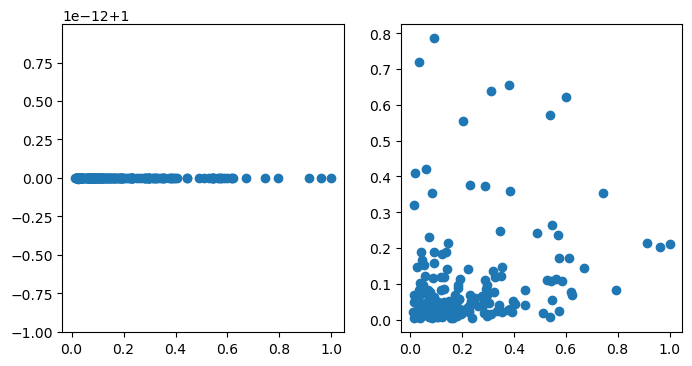

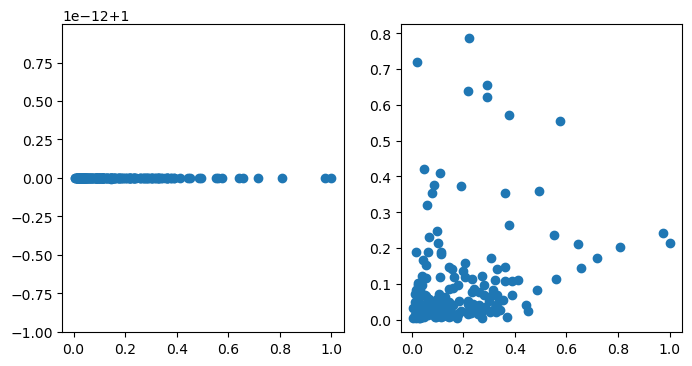

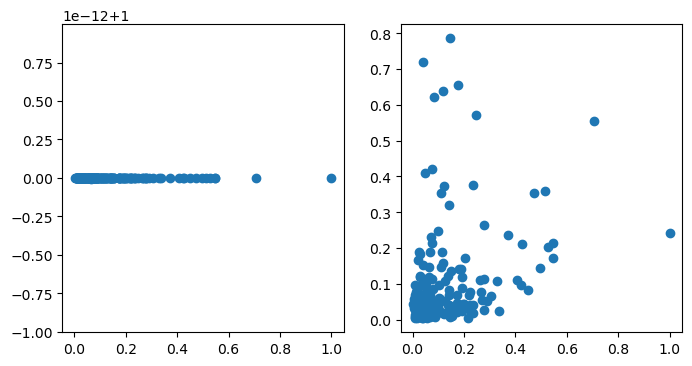

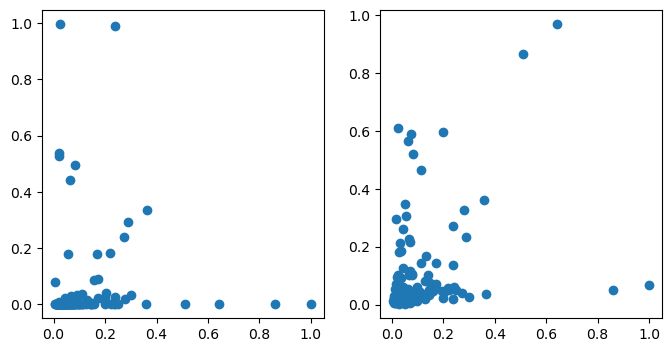

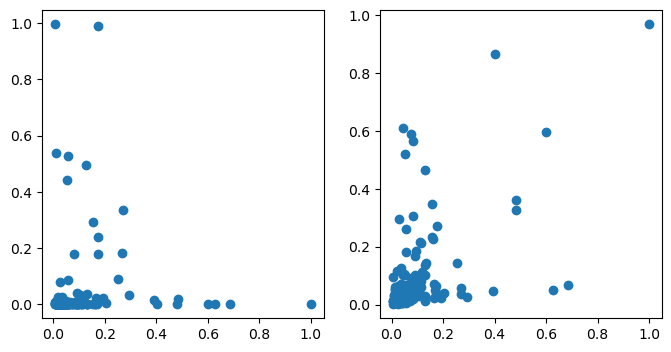

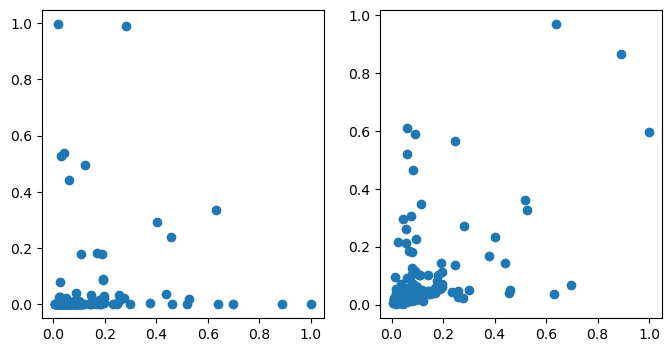

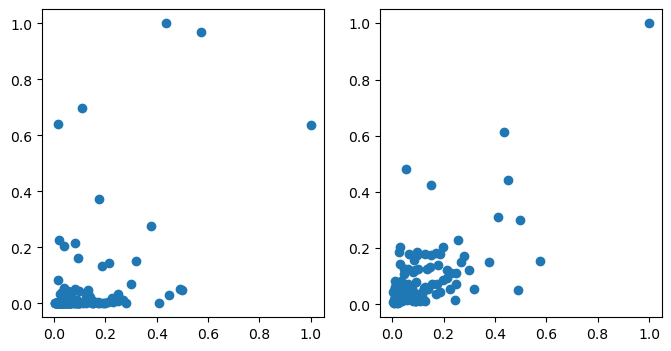

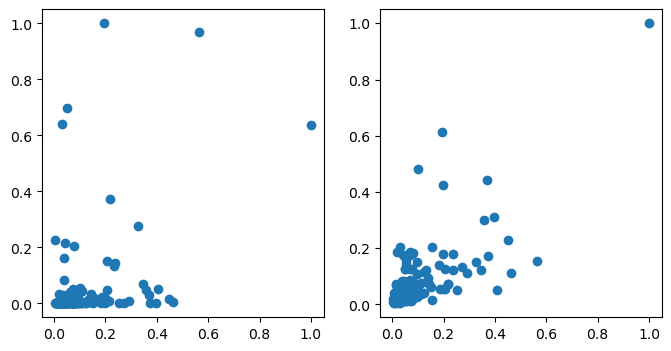

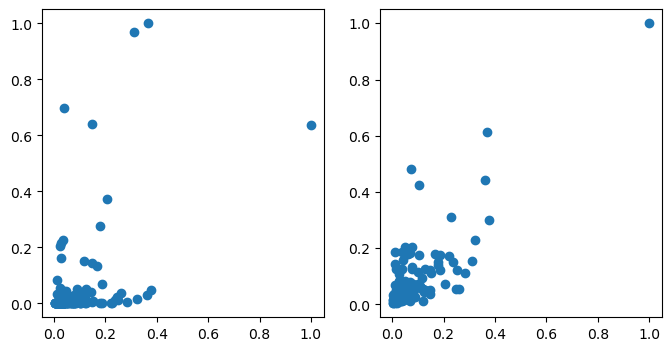

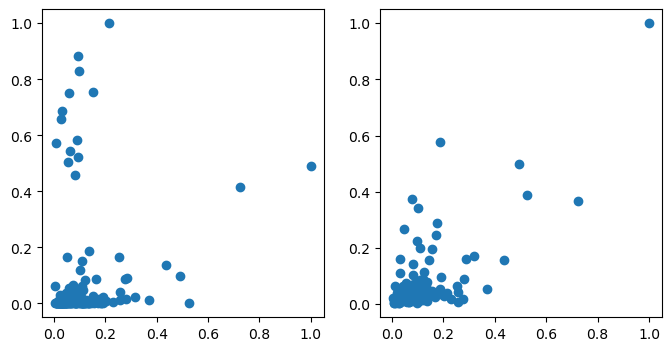

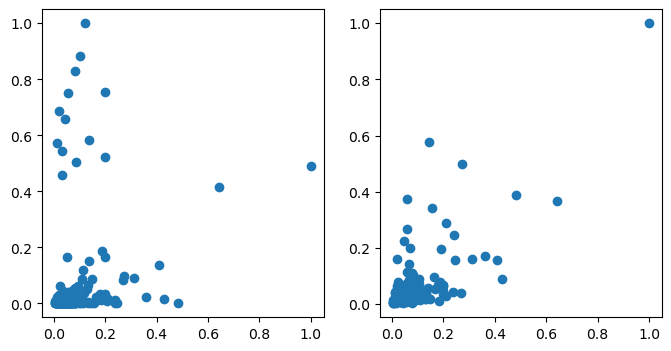

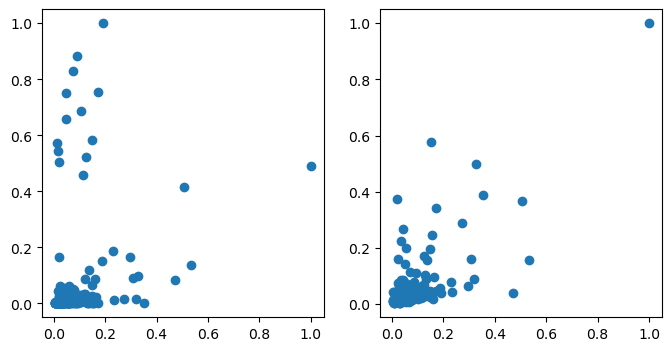

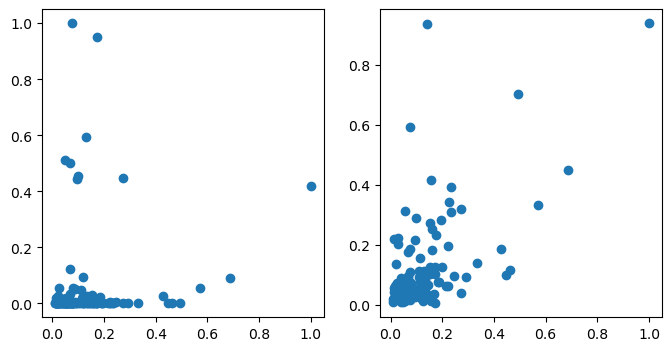

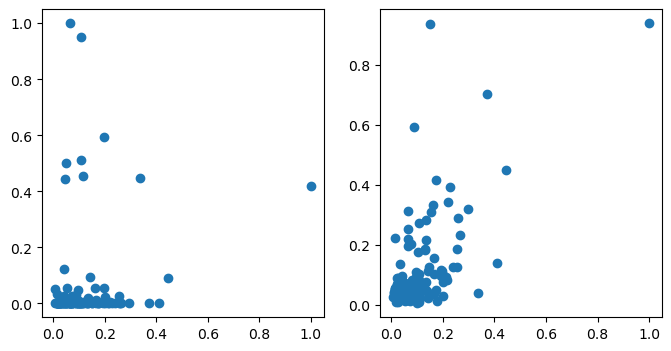

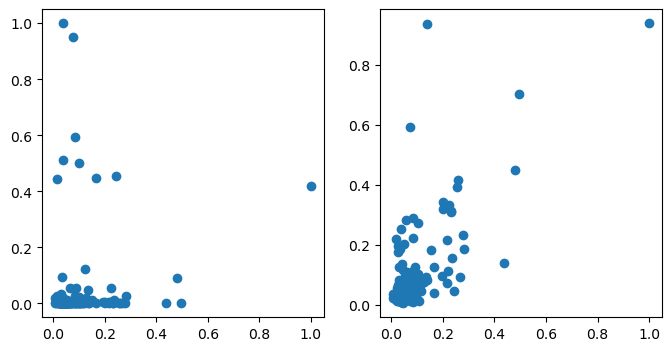

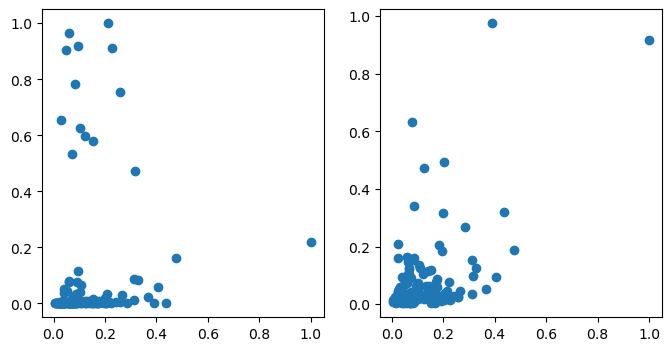

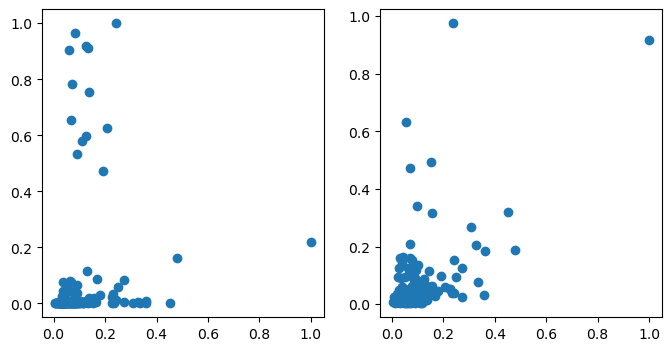

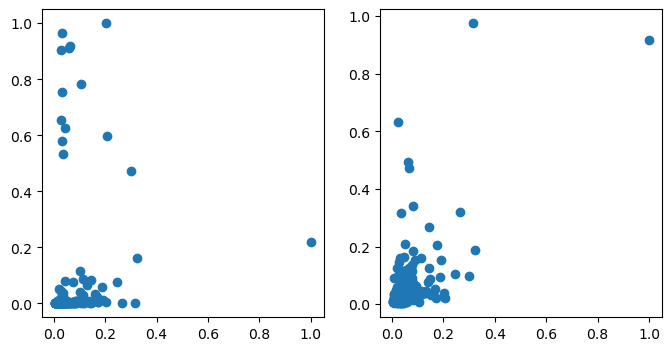

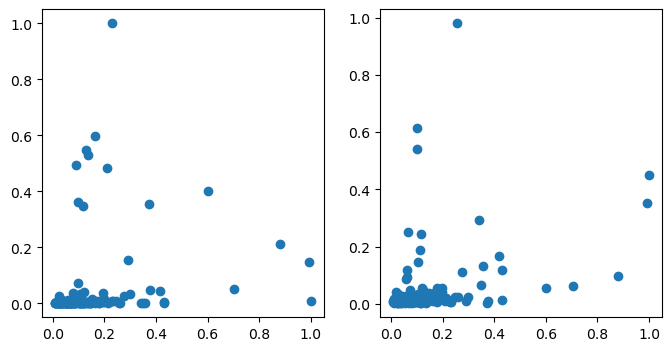

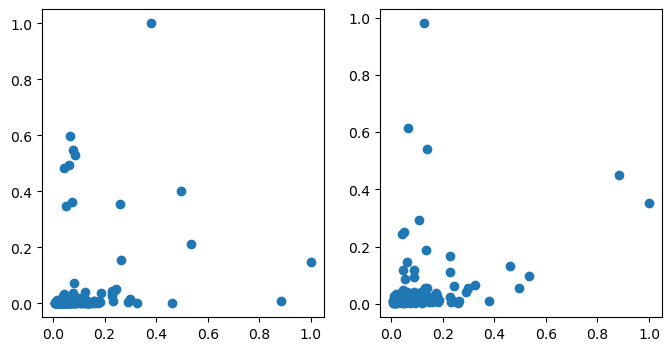

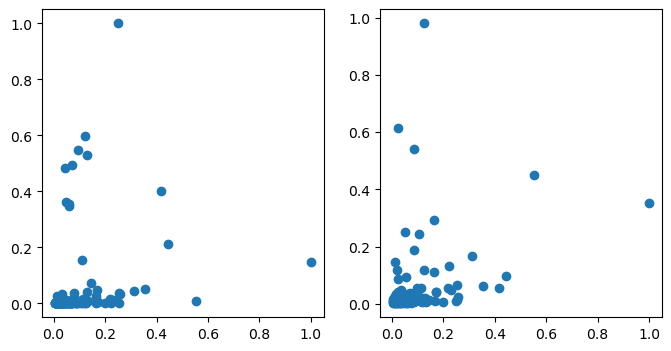

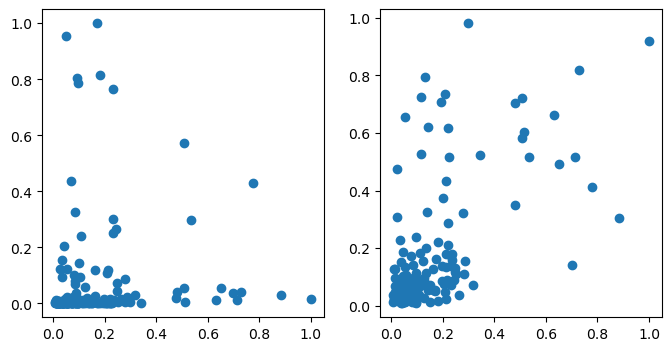

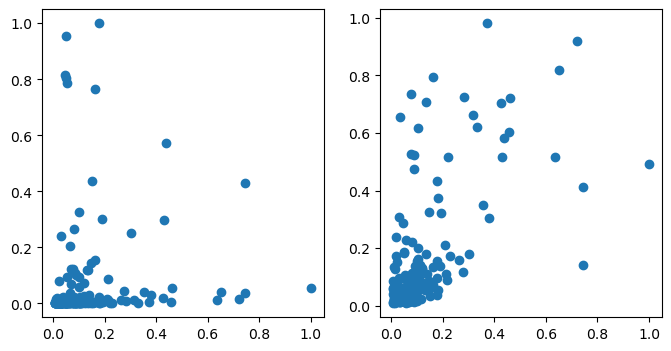

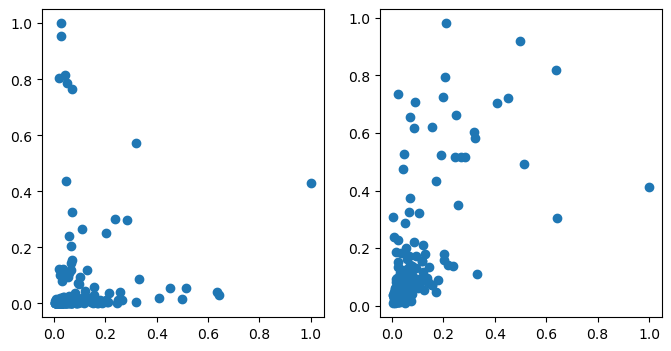

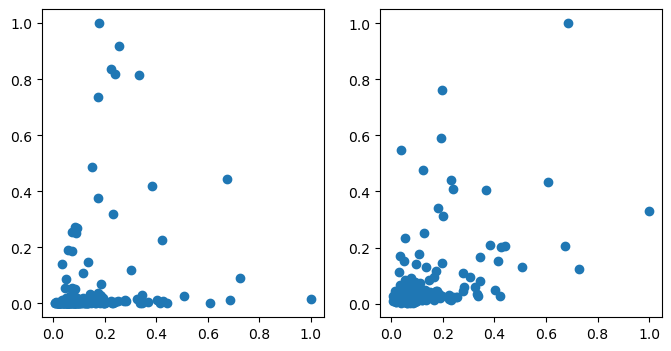

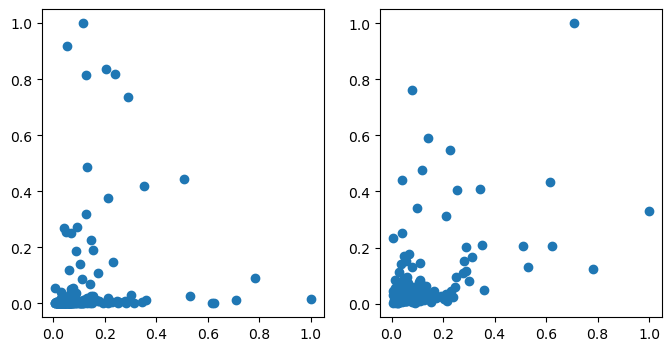

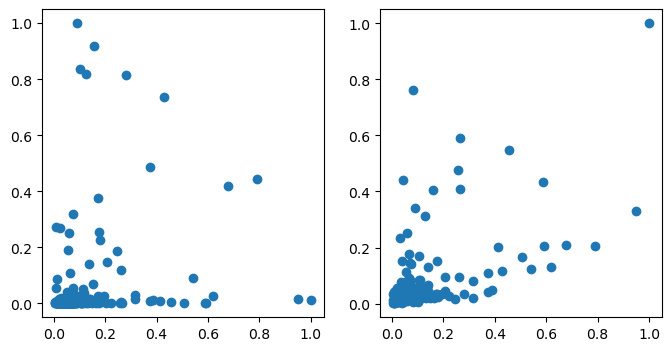

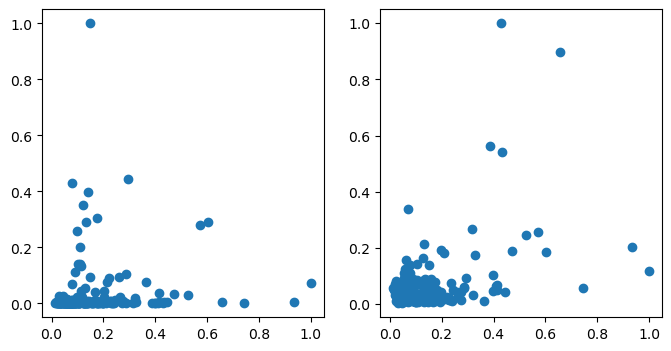

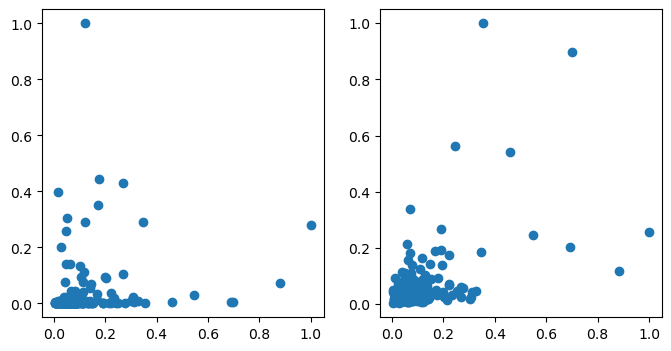

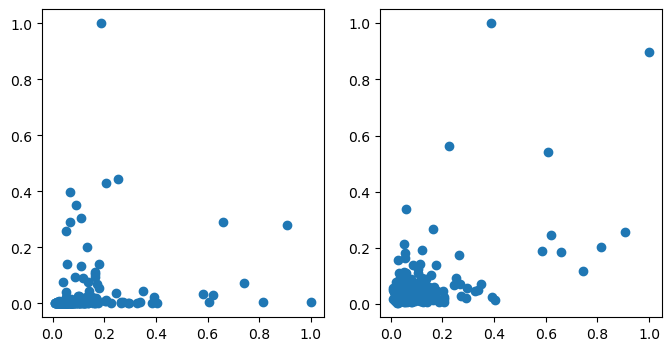

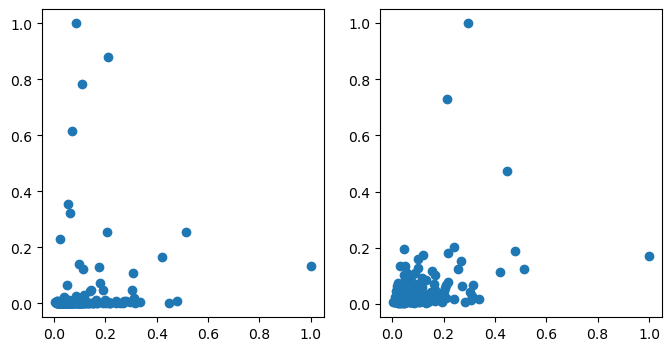

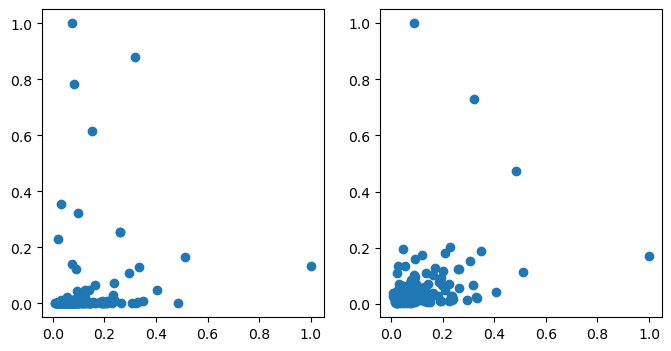

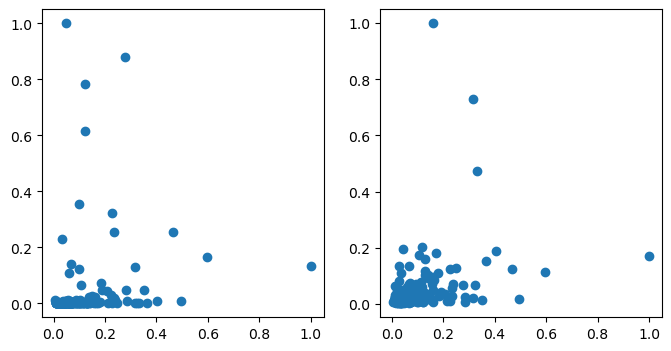

In [97]:
for i in range(len(rl)):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].scatter(rl[i]['cca_loadings'], rl[i]['pca_loadings'])
    ax[1].scatter(rl[i]['cca_loadings'], rl[i]['lqg_loadings'])
    fig.savefig('/home/akumar/nse/neural_control/figs/cca_loading_scatters/%i.png')

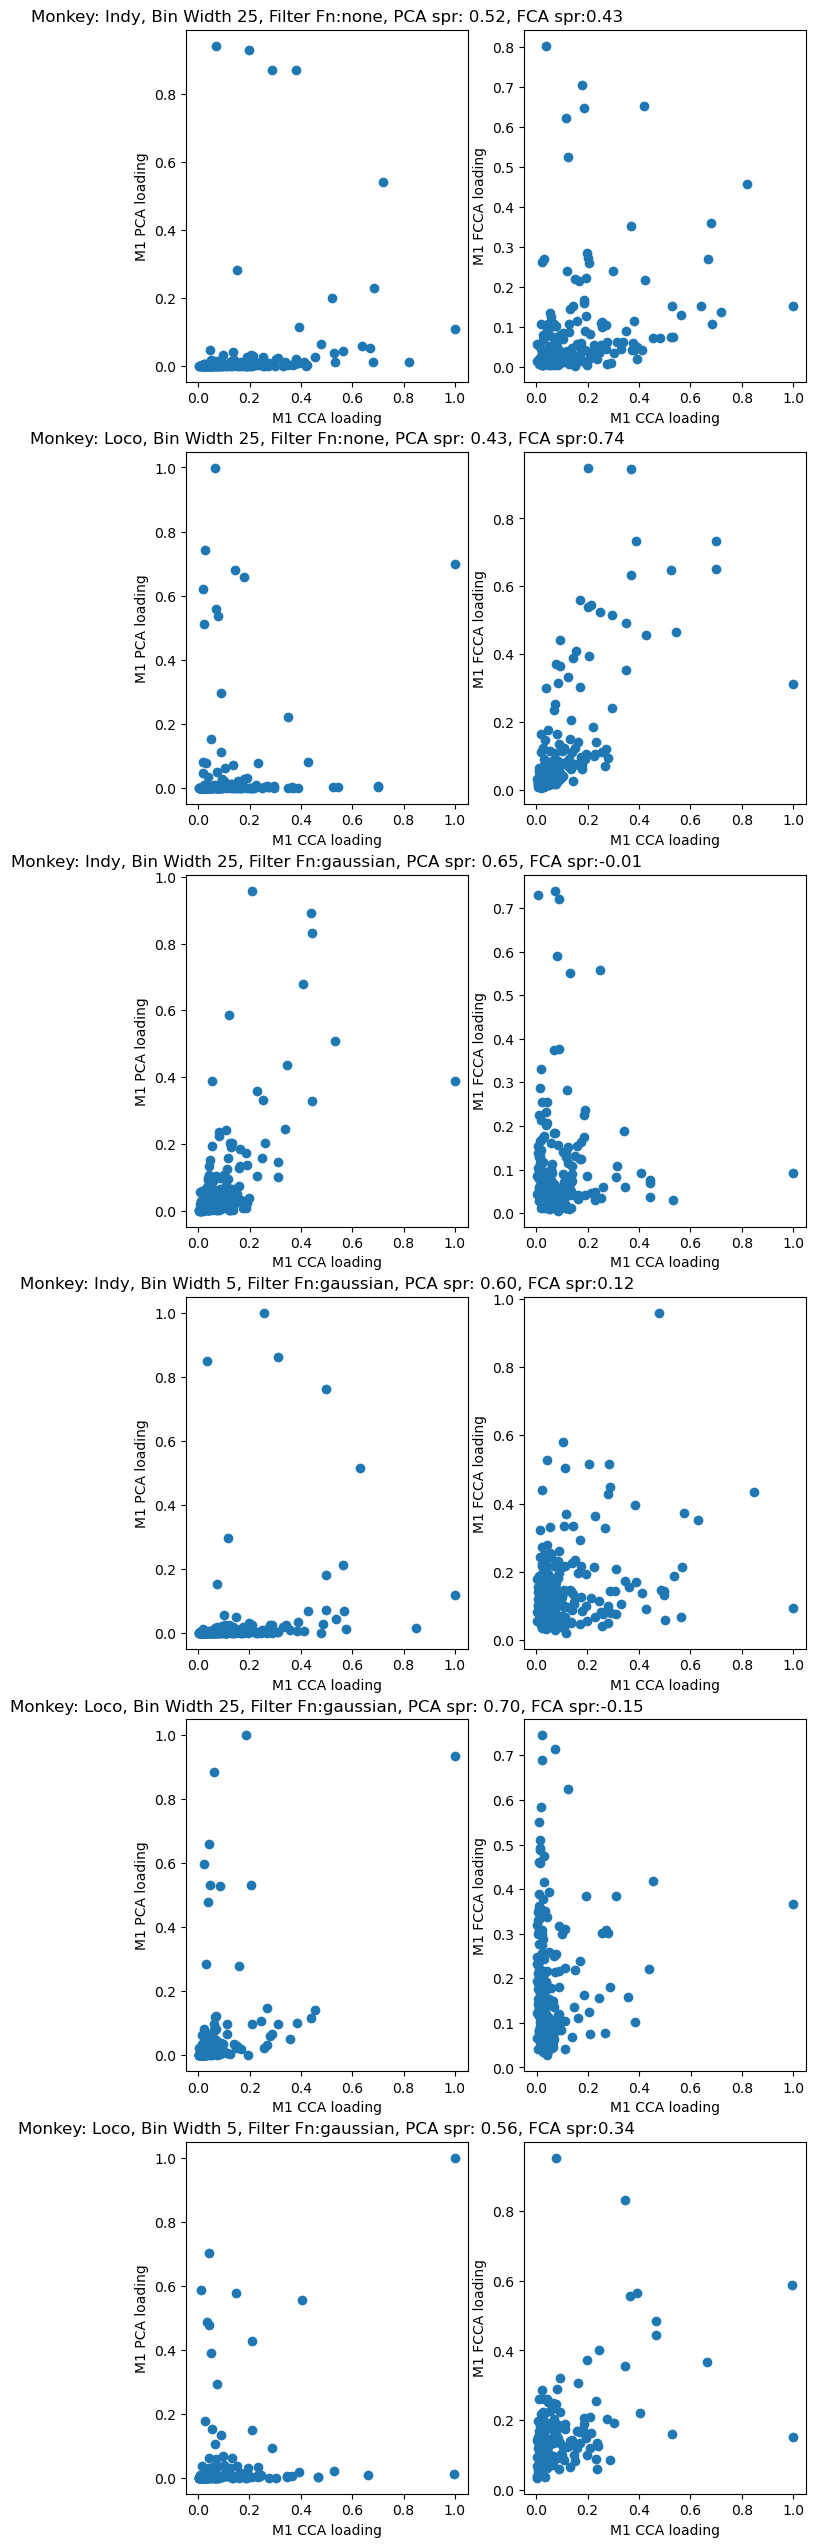

In [74]:
fig, ax = plt.subplots(6, 2, figsize=(8, 32))
for i in range(6):
    if rl[i]['didx'] == 0:
        monkey = 'Indy'
    elif rl[i]['didx'] == 1:
        monkey = 'Loco'

    ax[i, 0].scatter(rl[i]['cca_loadings'], rl[i]['pca_loadings'])
    ax[i, 0].set_xlabel('M1 CCA loading')
    ax[i, 0].set_ylabel('M1 PCA loading')

    ax[i, 1].scatter(rl[i]['cca_loadings'], rl[i]['lqg_loadings'])
    ax[i, 1].set_xlabel('M1 CCA loading')
    ax[i, 1].set_ylabel('M1 FCCA loading')

    r1 = scipy.stats.spearmanr(rl[i]['cca_loadings'], rl[i]['pca_loadings'])[0]
    r2 = scipy.stats.spearmanr(rl[i]['cca_loadings'], rl[i]['lqg_loadings'])[0]

    ax[i, 0].set_title('Monkey: %s, Bin Width %d, Filter Fn:%s, PCA spr: %.2f, FCA spr:%.2f' % (monkey, rl[i]['bin_width'], rl[i]['filter_fn'], r1, r2))

fig.savefig('/home/akumar/nse/neural_control/figs/timescales/cc_ss_loadings.pdf', bbox_inches='tight', pad_inches=0)


In [ ]:
# Recall that we decided we would look at modulations over the timecourse of a reach. Repeat the above exercise accordingly

### Time Resolved

In [8]:
from segmentation import reach_segment_sabes

In [12]:
with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
    rl = pickle.load(f)

sabes_df = pd.DataFrame(rl)

data_idx = 0
data_file = np.unique(sabes_df['data_file'].values)[data_idx]

dat = load_sabes(data_file)
# dat = reach_segment_sabes(dat, art_times[data_file.split('/')[-1].split('.mat')[0]])

fls = glob.glob('/home/akumar/nse/neural_control/data/s1m1regvt/*.dat')
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    lidx = int(fl.split('lidx')[1].split('_')[0])
    # dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[4:]

    pdb.set_trace()
    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-2]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        window_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['error_filter'] = error_filter
    result['window_filter'] = window_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['dim'] = 6
    result['measure_from_end'] = measure_from_end

    for k, v in filter_params.items():
        result[k] = v
    
    rl.append(result)
dvt_df = pd.DataFrame(rl)

> /tmp/ipykernel_11221/1319741674.py(22)<cell line: 14>()
     20 
     21     pdb.set_trace()
---> 22     filter_params = {}
     23     filter_params['error_thresh'] = float(s[7])/100
     24     filter_params['error_op'] = s[-2]

['rf', '0', 'op', 'le', 'q', '0', 'et', '100', 'eop', 'le', '0.dat']
